In [1]:
import os.path
import re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation
from matplotlib.animation import FuncAnimation
import yt
import glob
import pandas as pd
import math
from matplotlib.backends.backend_pdf import PdfPages
mpl.rcParams['figure.dpi'] = 100
import logging
import inspect

from mpl_toolkits.axes_grid1 import Size, Divider
from yt.config import ytcfg
# import sys

/home/dbeckers/.conda/envs/postprocessing_v2/lib/python3.9/site-packages/yt/utilities/logger.py:4: VisibleDeprecationWarning: The configuration file /home/dbeckers/.config/yt/ytrc is deprecated in favor of /home/dbeckers/.config/yt/yt.toml. Currently, both are present. Please manually remove the deprecated one to silence this warning.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  from yt.config import ytcfg


In [16]:
yt.set_log_level(50)

In [6]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [7]:
def natural_sort(l):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split("([0-9]+)", key)]
    return sorted(l, key=alphanum_key)

In [8]:
methods = ['godunov_ppm','godunov_weno_z','mol_central']; grid_types = ['fine_to_coarse']

color_list = [
    "#EE2E2F",
    "#008C48",
    "#185AA9",
    "#F47D23",
    "#662C91",
    "#A21D21",
    "#B43894",
    "#010202",
]
linestyle_list = [
    "solid",
    "dashed",
    "dotted",
    "dashdot"
]
linewidth_list = [
    1.5,
    0.5
]

In [9]:
def postprocess_error(case,t,root_dir,methods,grid_types,grid_sizes,
                ax,line_styles,line_colors,line_widths,plotting=True,line_configuration=1):
    t_list = []
    v_error_list = []
    i_method = -1
    for method in methods:
        i_method += 1
        v_errors_list_method = []
        t_list_method = []
        i_grid_type = -1
        for grid_type in grid_types:
            i_grid_type += 1
            i_grid_size = -1
            for grid_size in grid_sizes:
                i_grid_size += 1

                case_dir = os.path.join(root_dir, method, case, grid_type, f'nx_{grid_size}')

                error_file = os.path.join(case_dir,'ctv.log')
                with open(error_file) as f:
                    lines = f.readlines()
                    error_levels = int((len(lines[1].split())-1)/6)-1
                    time = [float(line.split()[0]) for line in lines[1:]]
                    idx = time.index(min(time, key=lambda x:abs(x-t)))+1
                    
                    v_errors_grid_size = []

                    for level in reversed(range(error_levels)):
                        v_errors_grid_size.append([float(line.split()[(level-1)*6+2]) for line in lines[1:idx]])
                    v_errors_grid_size.append([float(line.split()[-5]) for line in lines[1:idx]])
                    v_errors_list_method.append(v_errors_grid_size)
                    t_list_method.append(time[:idx])

                    if plotting:
                        for level in range(error_levels):
                            if line_configuration == 1:
                                ax.plot(time[:idx], v_errors_grid_size[level], label=f'{method}; nx = {grid_size}; grid type = {grid_type}', color=line_colors[i_grid_size], linewidth=line_widths[i_grid_type], linestyle=line_styles[i_method])
                            else:
                                ax.plot(time[:idx], v_errors_grid_size[level], label=f'{method}; nx = {grid_size}; grid type = {grid_type}', color=line_colors[i_method], linewidth=line_widths[i_grid_type], linestyle=line_styles[i_grid_size])
        
            
        t_list.append(t_list_method)
        v_error_list.append(v_errors_list_method)
        
    return t_list, v_error_list

In [10]:
def postprocess_dist(case,idx,root_dir,methods,grid_types,grid_sizes,
                ax,line_styles,line_colors,line_widths,plotting=True,line_configuration=1,print_dir=False,ray_start=(0,0,0),ray_end=(1,0,0)):
    
    i_method = -1
    for method in methods:
        i_method += 1
        i_grid_type = -1
        for grid_type in grid_types:
            i_grid_type += 1
            i_grid_size = -1
            for grid_size in grid_sizes:
                i_grid_size += 1

                case_dir = os.path.join(root_dir, method, case, grid_type, f'nx_{grid_size}')

                # Load plt files
                plt_files = natural_sort(glob.glob(os.path.join(case_dir, "plt*")))
                
                ds = yt.load(plt_files[idx])
                ray = ds.ray(ray_start,ray_end)
                srt = np.argsort(ray[("gas","x")])
                df = pd.DataFrame({k: np.array(ray[f][srt]) for k,f in zip(["x","velocityy"],[("gas","x"),("boxlib","velocityy")])})
                t = ds.current_time.value.flatten()[0]
                df["time"] = t
                df["dx"] = [ray.fwidth[i][0].value.flatten()[0] for i in range(len(df["x"].values))]
                
                # Plot scalar distribution
                if plotting == True:
                    if line_configuration == 1:
                        ax.plot(df["x"].values, df["velocityy"].values, label=f'{method}; nx = {grid_size}; grid type = {grid_type}; t = {t}', color=line_colors[i_grid_size], linewidth=line_widths[i_grid_type], linestyle=line_styles[i_method])
                    else:
                        ax.plot(df["x"].values, df["velocityy"].values, label=f'{method}; nx = {grid_size}; grid type = {grid_type}; t = {t}', color=line_colors[i_method], linewidth=line_widths[i_grid_type], linestyle=line_styles[i_grid_size])
    return t, df["x"].values, df["velocityy"].values, ds
            

In [11]:
root_dir = '/scratch/dbeckers/ctv'

# Uniform grid

Text(0.5, 1.0, 't = 1.0; wavenumbers = 8 pi; CFL = 0.45')

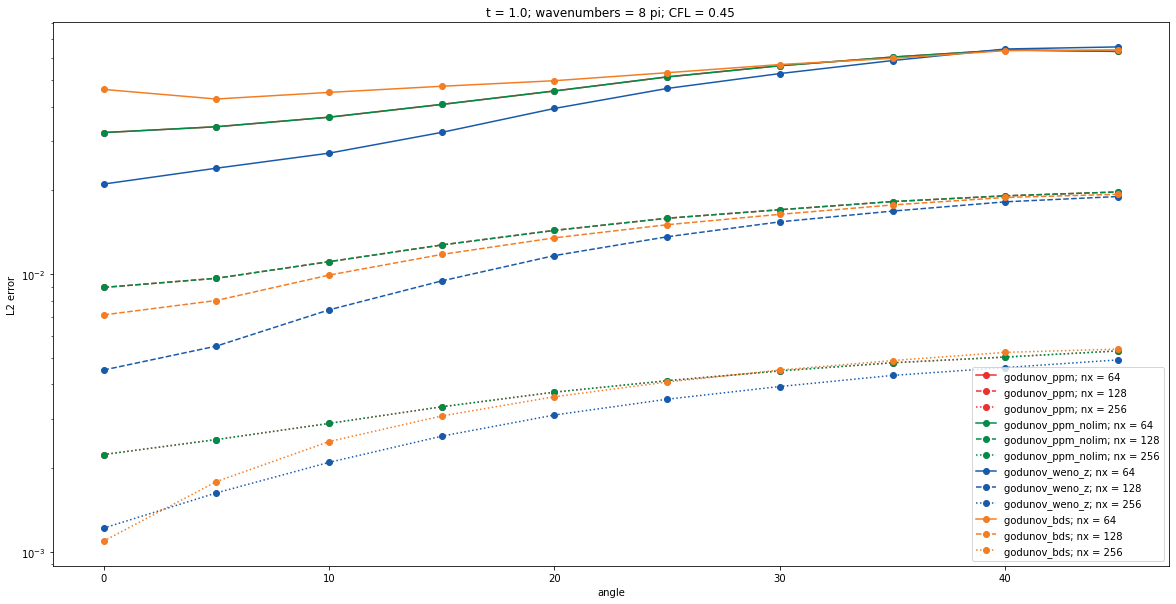

In [12]:
fig, ax = plt.subplots(figsize=(20,10))
angles = range(0,50,5); methods = ['godunov_ppm','godunov_ppm_nolim','godunov_weno_z','godunov_bds']; grid_sizes = [64,128,256];
for i_method in range(len(methods)):
    for i_grid_size in range(len(grid_sizes)):    
        error_method = []
        for angle in angles:
            t_list, error_list = postprocess_error(f'{angle}_degrees_CFL_0.45',0.5,root_dir,[methods[i_method]],['uniform'],[grid_sizes[i_grid_size]],None,None,None,None,plotting=False)
            error_method.append(error_list[0][0][-1][-1])
        ax.plot(angles,error_method,label=f'{methods[i_method]}; nx = {grid_sizes[i_grid_size]}',marker='o',color=color_list[i_method],linestyle=linestyle_list[i_grid_size])
        
ax.legend()
ax.set_xlabel('angle')
ax.set_ylabel('L2 error')
ax.set_yscale('log')
ax.set_title('t = 1.0; wavenumbers = 8 pi; CFL = 0.45')

Text(0.5, 1.0, 't = 1.0; wavenumbers = 8 pi; CFL = 0.9')

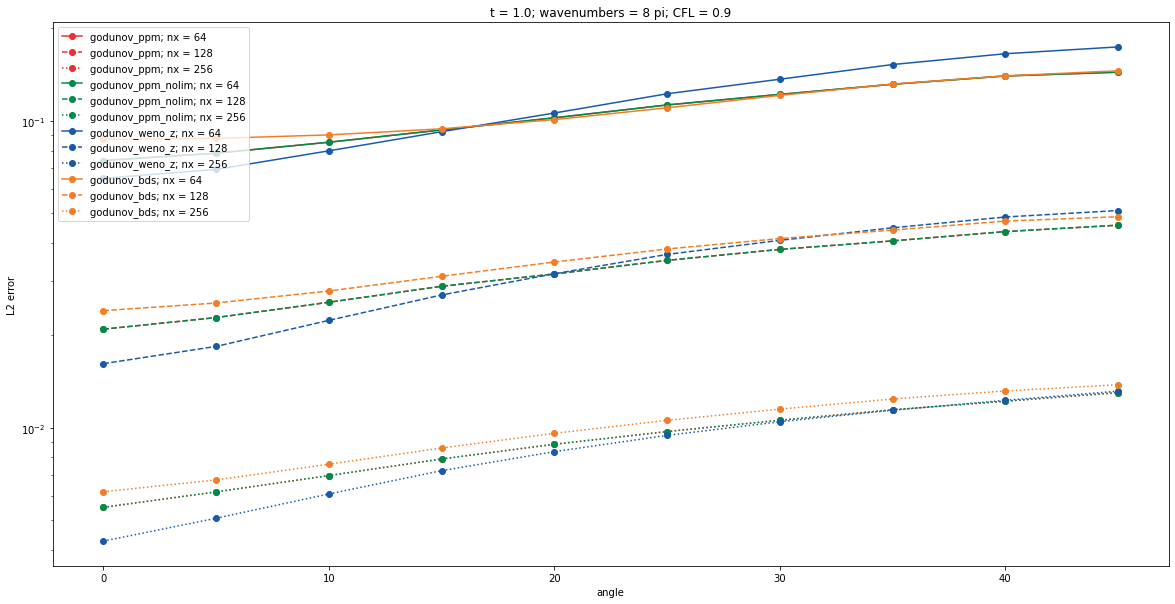

In [138]:
fig, ax = plt.subplots(figsize=(20,10))
angles = range(0,50,5); methods = ['godunov_ppm','godunov_ppm_nolim','godunov_weno_z','godunov_bds']; grid_sizes = [64,128,256];
for i_method in range(len(methods)):
    for i_grid_size in range(len(grid_sizes)):    
        error_method = []
        for angle in angles:
            t_list, error_list = postprocess_error(f'{angle}_degrees_CFL_0.9',0.5,root_dir,[methods[i_method]],['uniform'],[grid_sizes[i_grid_size]],None,None,None,None,plotting=False)
            error_method.append(error_list[0][0][-1][-1])
        ax.plot(angles,error_method,label=f'{methods[i_method]}; nx = {grid_sizes[i_grid_size]}',marker='o',color=color_list[i_method],linestyle=linestyle_list[i_grid_size])
        
ax.legend()
ax.set_xlabel('angle')
ax.set_ylabel('L2 error')
ax.set_yscale('log')
ax.set_title('t = 1.0; wavenumbers = 8 pi; CFL = 0.9')

yt : [INFO     ] 2022-09-07 10:37:06,183 Parameters: current_time              = 4.001424692199864
yt : [INFO     ] 2022-09-07 10:37:06,184 Parameters: domain_dimensions         = [128 128   4]
yt : [INFO     ] 2022-09-07 10:37:06,185 Parameters: domain_left_edge          = [-0.5      -0.5      -0.015625]
yt : [INFO     ] 2022-09-07 10:37:06,186 Parameters: domain_right_edge         = [0.5      0.5      0.015625]
yt : [DEBUG    ] 2022-09-07 10:37:06,189 Initializing data storage.
yt : [DEBUG    ] 2022-09-07 10:37:06,189 Setting up domain geometry.
yt : [DEBUG    ] 2022-09-07 10:37:06,190 Counting grids.
yt : [DEBUG    ] 2022-09-07 10:37:06,191 Initializing grid arrays.
yt : [DEBUG    ] 2022-09-07 10:37:06,192 Allocating arrays for 1024 grids
yt : [DEBUG    ] 2022-09-07 10:37:06,192 Parsing index.
yt : [DEBUG    ] 2022-09-07 10:37:06,207 Appending object to plt01943 (type: <class 'yt.frontends.boxlib.data_structures.BoxlibGrid'>)
yt : [DEBUG    ] 2022-09-07 10:37:06,264 Constructing gri

yt : [DEBUG    ] 2022-09-07 10:37:06,635 Succeeded with ('boxlib', 'gpy') (needs {('boxlib', 'gpy')})
yt : [DEBUG    ] 2022-09-07 10:37:06,636 Succeeded with ('boxlib', 'p') (needs {('boxlib', 'p')})
yt : [DEBUG    ] 2022-09-07 10:37:06,636 Succeeded with ('boxlib', 'velocityx') (needs {('boxlib', 'velocityx')})
yt : [DEBUG    ] 2022-09-07 10:37:06,637 Succeeded with ('boxlib', 'velocityy') (needs {('boxlib', 'velocityy')})
yt : [DEBUG    ] 2022-09-07 10:37:06,638 Succeeded with ('index', 'dx') (needs set())
yt : [DEBUG    ] 2022-09-07 10:37:06,638 Succeeded with ('index', 'path_element_x') (needs set())
yt : [DEBUG    ] 2022-09-07 10:37:06,639 Succeeded with ('index', 'x') (needs set())
yt : [DEBUG    ] 2022-09-07 10:37:06,641 Succeeded with ('index', 'vertex_x') (needs set())
yt : [DEBUG    ] 2022-09-07 10:37:06,641 Succeeded with ('index', 'dy') (needs set())
yt : [DEBUG    ] 2022-09-07 10:37:06,642 Succeeded with ('index', 'path_element_y') (needs set())
yt : [DEBUG    ] 2022-09-07

yt : [DEBUG    ] 2022-09-07 10:37:07,507 Setting up domain geometry.
yt : [DEBUG    ] 2022-09-07 10:37:07,507 Counting grids.
yt : [DEBUG    ] 2022-09-07 10:37:07,509 Initializing grid arrays.
yt : [DEBUG    ] 2022-09-07 10:37:07,510 Allocating arrays for 1024 grids
yt : [DEBUG    ] 2022-09-07 10:37:07,510 Parsing index.
yt : [DEBUG    ] 2022-09-07 10:37:07,527 Appending object to plt01943 (type: <class 'yt.frontends.boxlib.data_structures.BoxlibGrid'>)
yt : [DEBUG    ] 2022-09-07 10:37:07,588 Constructing grid objects.
yt : [DEBUG    ] 2022-09-07 10:37:07,588 Creating grid objects
yt : [DEBUG    ] 2022-09-07 10:37:07,590 Prepared       0 /    1024 grids
yt : [DEBUG    ] 2022-09-07 10:37:07,613 Done creating grid objects
yt : [DEBUG    ] 2022-09-07 10:37:07,614 Re-examining index
yt : [DEBUG    ] 2022-09-07 10:37:07,615 Initializing data grid data IO
yt : [DEBUG    ] 2022-09-07 10:37:07,615 Detecting fields.
yt : [DEBUG    ] 2022-09-07 10:37:07,616 FAB header suggests dtype of <f8
yt :

yt : [DEBUG    ] 2022-09-07 10:37:07,768 Succeeded with ('boxlib', 'velocityx') (needs {('boxlib', 'velocityx')})
yt : [DEBUG    ] 2022-09-07 10:37:07,769 Succeeded with ('boxlib', 'velocityy') (needs {('boxlib', 'velocityy')})
yt : [DEBUG    ] 2022-09-07 10:37:07,769 Succeeded with ('index', 'dx') (needs set())
yt : [DEBUG    ] 2022-09-07 10:37:07,770 Succeeded with ('index', 'path_element_x') (needs set())
yt : [DEBUG    ] 2022-09-07 10:37:07,771 Succeeded with ('index', 'x') (needs set())
yt : [DEBUG    ] 2022-09-07 10:37:07,773 Succeeded with ('index', 'vertex_x') (needs set())
yt : [DEBUG    ] 2022-09-07 10:37:07,773 Succeeded with ('index', 'dy') (needs set())
yt : [DEBUG    ] 2022-09-07 10:37:07,774 Succeeded with ('index', 'path_element_y') (needs set())
yt : [DEBUG    ] 2022-09-07 10:37:07,775 Succeeded with ('index', 'y') (needs set())
yt : [DEBUG    ] 2022-09-07 10:37:07,776 Succeeded with ('index', 'vertex_y') (needs set())
yt : [DEBUG    ] 2022-09-07 10:37:07,777 Succeeded

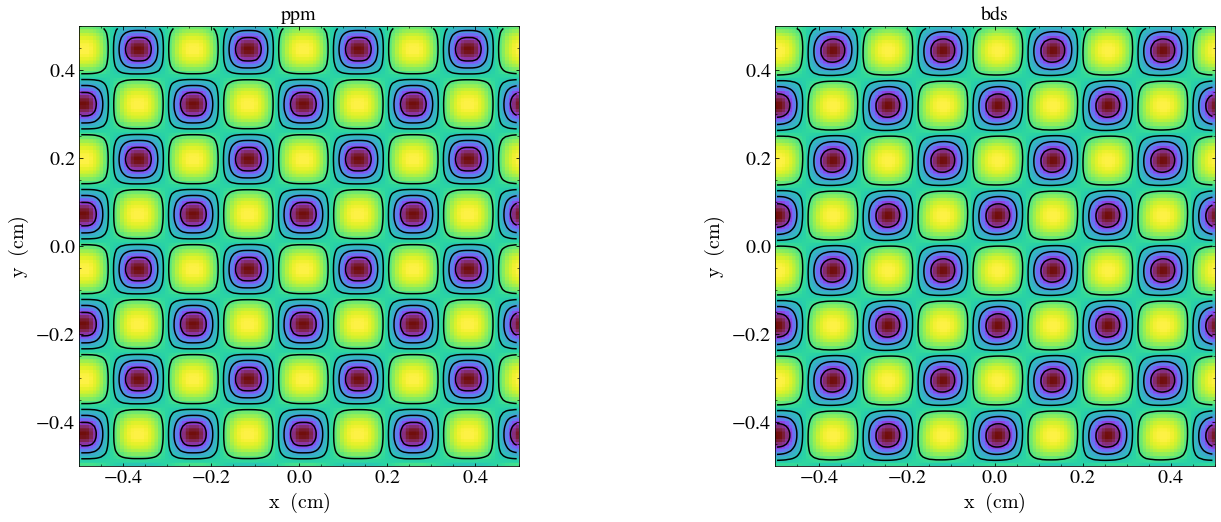

In [15]:
ds1 = yt.load('/scratch/dbeckers/ctv/deformation_test/ppm/plt01943')
slp1 = yt.SlicePlot(ds1, "z", ("boxlib","velocityy"), fontsize=20, origin='native')
slp1.set_figure_size(20)
slp1.annotate_title('ppm')
slp1.annotate_contour(("boxlib","velocityy"),ncont=10,clim=(-0.8,0.8),factor=4,take_log=False)
ds2 = yt.load('/scratch/dbeckers/ctv/deformation_test/bds/plt01943')
slp2 = yt.SlicePlot(ds2, "z", ("boxlib","velocityy"), fontsize=20, origin='native')
slp2.set_figure_size(20)
slp2.annotate_title('bds')
slp2.annotate_contour(("boxlib","velocityy"),ncont=10,clim=(-0.8,0.8),factor=4,take_log=False)

fig = plt.figure()

horiz = [Size.Scaled(1.), Size.Fixed(.5), Size.Scaled(2.)]
vert = [Size.Scaled(1.)]

rect = (0.1, 0.1, 0.8, 0.8)
div = Divider(fig, rect, horiz, vert, aspect=True)

# The rect parameter will actually be ignored and overridden by axes_locator.
ax1 = fig.add_axes(rect, axes_locator=div.new_locator(nx=0, ny=0))
ax2 = fig.add_axes(rect, axes_locator=div.new_locator(nx=2, ny=0))

slp1.plots[("boxlib","velocityy")].figure = fig
slp2.plots[("boxlib","velocityy")].figure = fig
slp1.plots[("boxlib","velocityy")].axes = ax1
slp2.plots[("boxlib","velocityy")].axes = ax2
slp1._setup_plots()
slp2._setup_plots()

Text(0.5, 1.0, 't = 1.0')

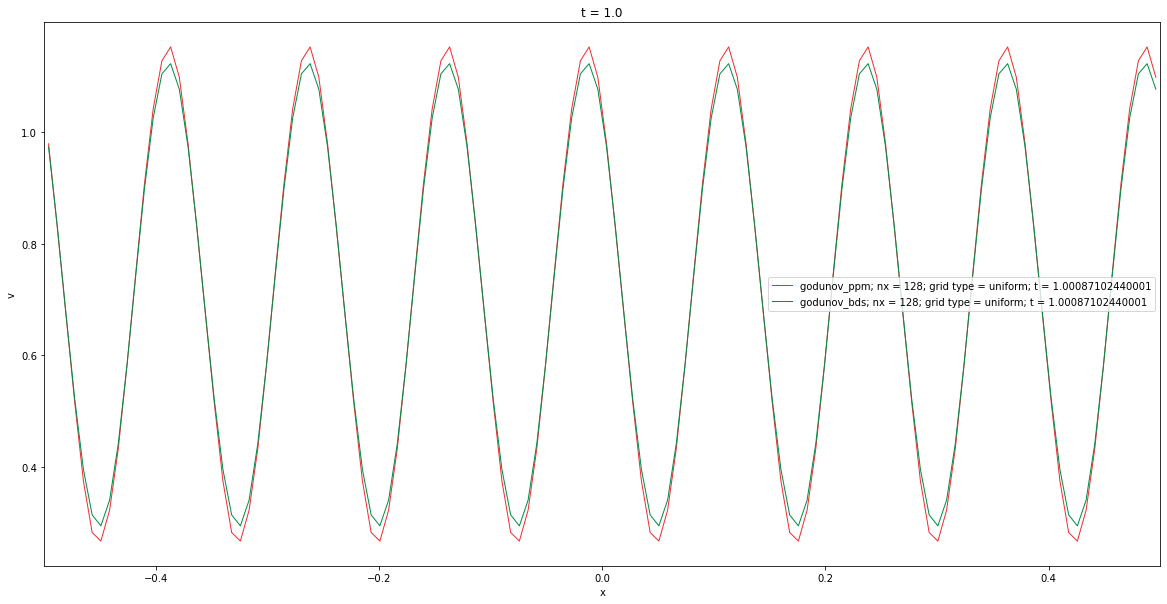

In [124]:
fig,ax = plt.subplots(figsize=(20,10))
t,_,_,_ = postprocess_dist('45_degrees_CFL_0.45',-1,root_dir,['godunov_ppm','godunov_bds'],['uniform'],[128],
                 ax,linestyle_list,color_list,[1.0],plotting=True,line_configuration=2,ray_start=(-0.5,-0.5,0),ray_end=(0.5,0.5,0))

ax.legend()
ax.set_xlim((-0.5,0.5))
ax.set_xlabel('x')
ax.set_ylabel('v')
ax.set_title('t = 1.0')

# Fine-to-coarse


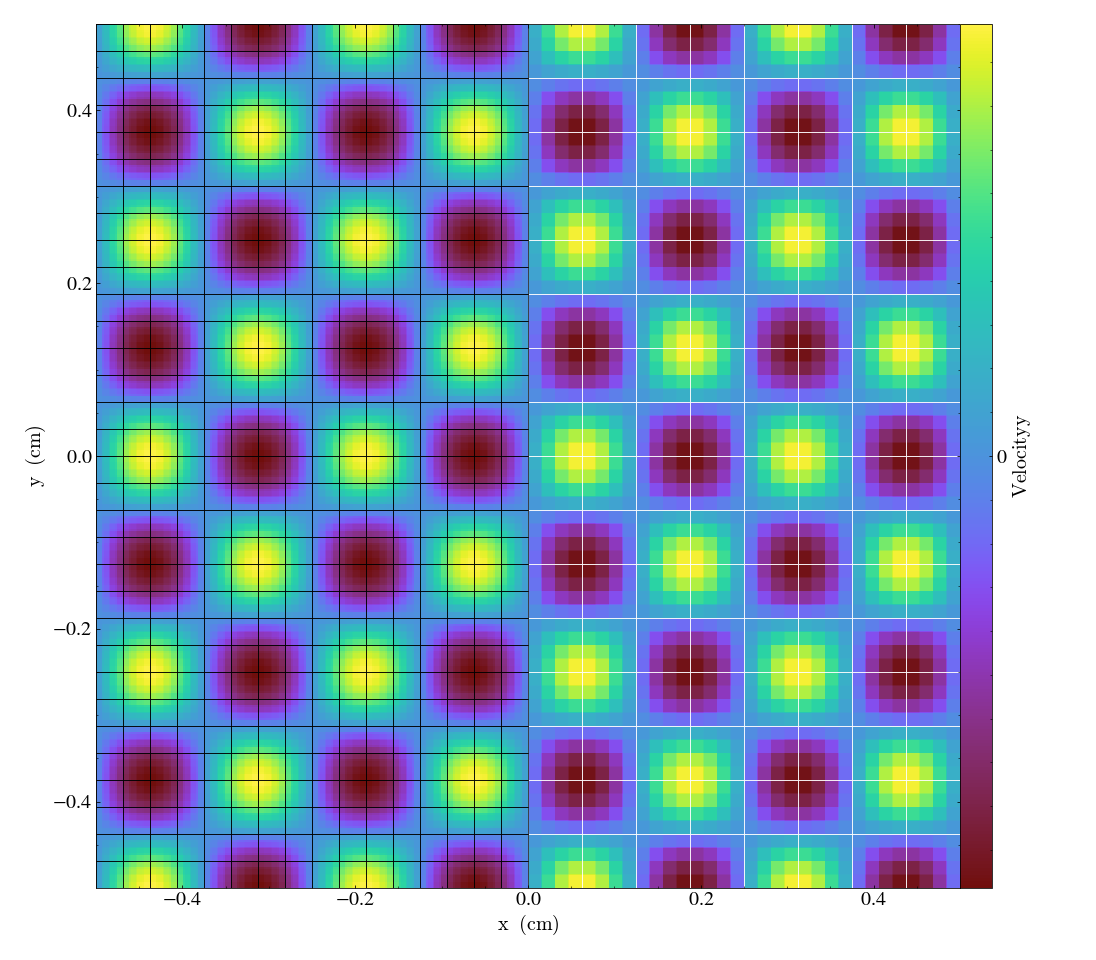

In [132]:
ds = yt.load('/scratch/dbeckers/ctv/godunov_ppm/0_degrees_CFL_0.45/fine_to_coarse/nx_64/plt00000')
slp = yt.SlicePlot(ds, "z", ("boxlib","velocityy"), fontsize=20, origin='native')
slp.set_figure_size(12)
slp.annotate_grids()
slp

Text(0.5, 1.0, 't = 1.0')

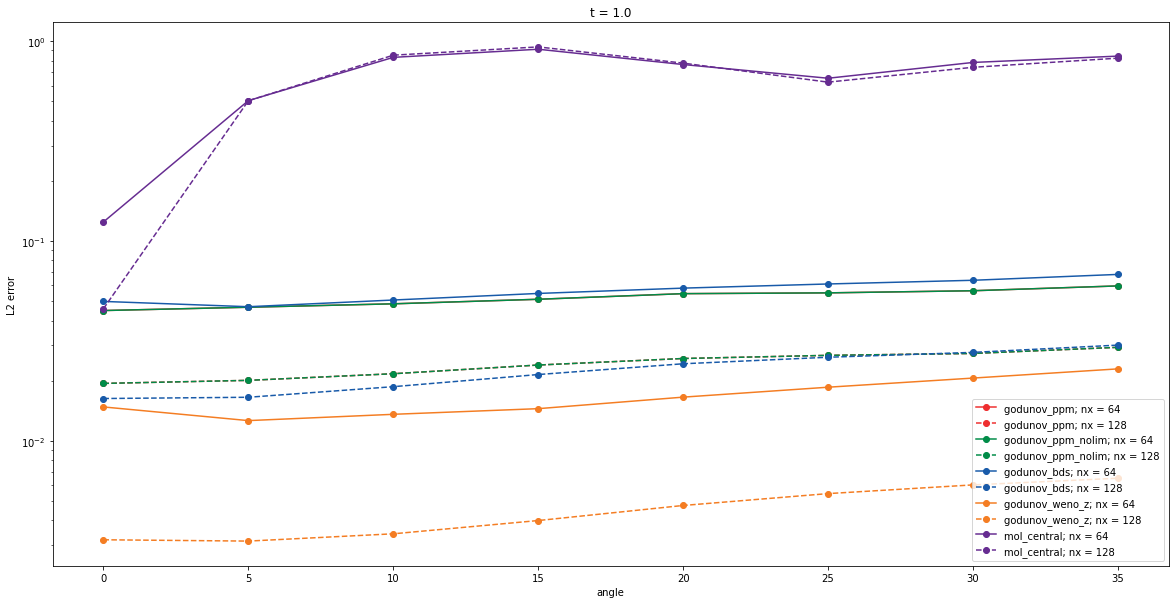

In [133]:
fig, ax = plt.subplots(figsize=(20,10))
angles = range(0,40,5); methods = ['godunov_ppm','godunov_ppm_nolim','godunov_bds','godunov_weno_z','mol_central']; grid_sizes = [64,128];
for i_method in range(len(methods)):
    for i_grid_size in range(len(grid_sizes)):    
        error_method = []
        for angle in angles:
            t_list, error_list = postprocess_error(f'{angle}_degrees_CFL_0.45',0.5,root_dir,[methods[i_method]],['fine_to_coarse'],[grid_sizes[i_grid_size]],None,None,None,None,plotting=False)
            error_method.append(error_list[0][0][-1][-1])
        ax.plot(angles,error_method,label=f'{methods[i_method]}; nx = {grid_sizes[i_grid_size]}',marker='o',color=color_list[i_method],linestyle=linestyle_list[i_grid_size])
        
ax.legend()
ax.set_xlabel('angle')
ax.set_ylabel('L2 error')
ax.set_yscale('log')
ax.set_title('t = 1.0')

Text(0.5, 1.0, 't = 1.0')

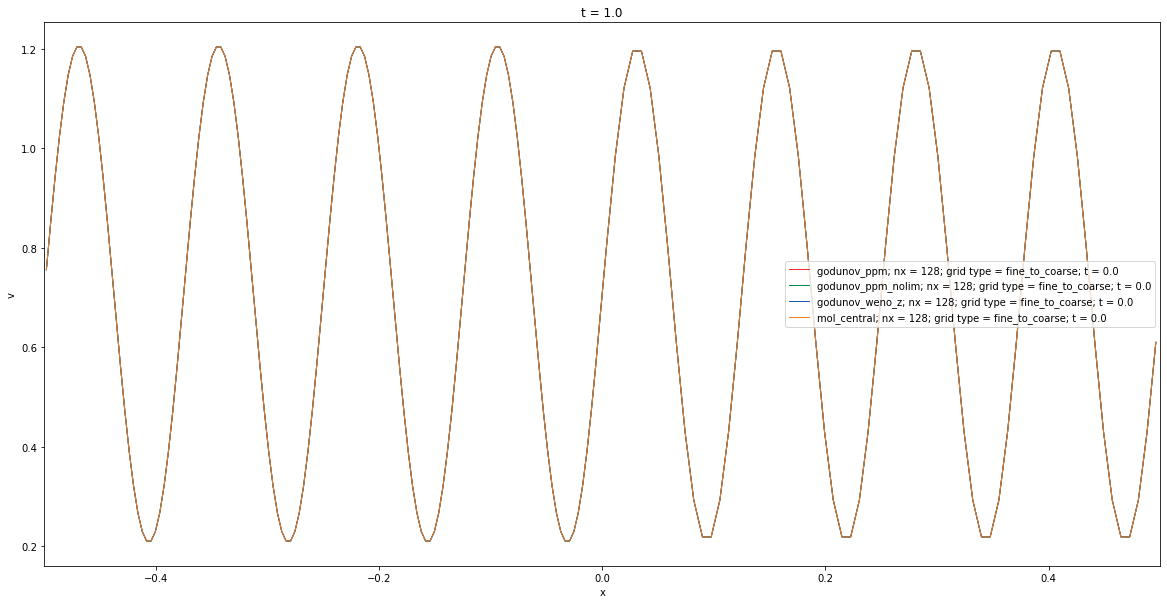

In [81]:
fig,ax = plt.subplots(figsize=(20,10))
t,_,_,_ = postprocess_dist('45_degrees_CFL_0.45',0,root_dir,['godunov_ppm','godunov_ppm_nolim','godunov_weno_z','mol_central'],['fine_to_coarse'],[128],
                 ax,linestyle_list,color_list,[1.0],plotting=True,line_configuration=2,ray_start=(-0.5,-0.5,0),ray_end=(0.5,0.5,0))

ax.legend()
ax.set_xlim((-0.5,0.5))
ax.set_xlabel('x')
ax.set_ylabel('v')
ax.set_title('t = 1.0')